In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.8 MB/s eta 0:00:00


In [ ]:
cd "/content/drive/MyDrive/Hate Speech Classification/kennedy"

/content/drive/MyDrive/Hate Speech Classification/kennedy


In [ ]:
import numpy as np
import pandas as pd
import time
import re
from tqdm import notebook
import seaborn as sns
import matplotlib.pyplot as plt

import os
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import AutoModel
from transformers import AutoTokenizer
from transformers import AutoConfig
from transformers import get_cosine_schedule_with_warmup

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import gc

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

In [ ]:
SEED = 875
seed_everything(SEED)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device.type)

Device:  cuda


# Dataset Loading & Processing

In [ ]:
train_data = pd.read_csv('kennedy_train.csv')
val_data = pd.read_csv('kennedy_dev.csv')
test_data = pd.read_csv('kennedy_test.csv')

In [ ]:
train_data = train_data[['comment_id', 'annotator_id', 'text', 'label']].copy()
val_data = val_data[['comment_id', 'annotator_id', 'text', 'label']].copy()
test_data = test_data[['comment_id', 'annotator_id', 'text', 'label']].copy()

In [ ]:
train_df = train_data.groupby('comment_id', as_index=False).agg({'text': 'first', 'label': 'first'})
val_df = val_data.groupby('comment_id', as_index=False).agg({'text': 'first', 'label': 'first'})
test_df = test_data.groupby('comment_id', as_index=False).agg({'text': 'first', 'label': 'first'})

In [ ]:
train_df.head()

,comment_id,text,label
0,1,White people are trash.,1
1,3,"I'm not saying you said that, I'm just saying ...",0
2,5,Fabrice Fabrice is ostensibly black or black/l...,0
3,7,\*points to posters asking for palestinian rig...,1
4,8,Guranteed at least one of these guys has raped...,2


In [ ]:
train_df.columns = ['id', 'text', 'label']
val_df.columns = ['id', 'text', 'label']
test_df.columns = ['id', 'text', 'label']

In [ ]:
train_df.head()

,id,text,label
0,1,White people are trash.,1
1,3,"I'm not saying you said that, I'm just saying ...",0
2,5,Fabrice Fabrice is ostensibly black or black/l...,0
3,7,\*points to posters asking for palestinian rig...,1
4,8,Guranteed at least one of these guys has raped...,2


# Model and Dataset

In [ ]:
BERT = 'bert-base-uncased'
ROBERTA = 'roberta-base'

MODEL_NAME = ROBERTA

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
MAX_LEN = 256
EPOCHS = 10
LEARNING_RATE = 5e-5
NUM_LABELS = 3
EVAL_PERIOD = 100

In [ ]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.len = len(df)
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        text = self.df.loc[index, 'text']
        text_id = self.df.loc[index, 'id']
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_len,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        if MODEL_NAME=='bert-base-uncased':
            token_type_ids = inputs['token_type_ids']
        else:
            token_type_ids = 1.

        target = self.df.loc[index, 'label']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'masks': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(target, dtype=torch.long),
            'text_ids': text_id
        }

    def __len__(self):
        return self.len

In [ ]:
class HateSpeechClassifier(torch.nn.Module):
    def __init__(self, model_name, dropout=True):
        super(HateSpeechClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.model_name = model_name

        if model_name == BERT:
            self.in_features = self.bert.pooler.dense.out_features
        elif model_name == ROBERTA:
            self.in_features = self.bert.pooler.dense.out_features
        else:
            self.in_features = 768

        self.dropout = torch.nn.Dropout(0.5)
        self.classifier = torch.nn.Linear(self.in_features, NUM_LABELS)

    def forward(self, input_ids, attention_mask, token_type_ids):
        if self.model_name == BERT:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  token_type_ids=token_type_ids,
                                                  return_dict=False)
        elif self.model_name == ROBERTA:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  return_dict=False)

        output = self.dropout(output)
        output = self.classifier(output)
        return output

# Training

In [ ]:
train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

valid_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
}

test_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
}

In [ ]:
def get_train_setup(train_df, val_df):
    train_data = TextDataset(train_df, tokenizer, MAX_LEN)
    val_data = TextDataset(val_df, tokenizer, MAX_LEN)

    train_loader = DataLoader(train_data, **train_params)
    val_loader = DataLoader(val_data, **valid_params)

    model = HateSpeechClassifier(MODEL_NAME)
    model.to(device)

    num_training_steps = EPOCHS*len(train_loader)

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)

    num_warmup_steps = 100
    scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_training_steps=num_training_steps,
        num_warmup_steps=num_warmup_steps,
    )

    return train_loader, val_loader, model, loss_function, optimizer, scheduler

In [ ]:
def calc_accuracy(preds, targets):
    accuracy = (preds==targets).cpu().numpy().mean() * 100
    return accuracy

In [ ]:
def train(model, model_output_path, loss_fn, optimizer, scheduler, train_dataloader, val_dataloader=None, epochs=5, evaluation=False):

    print("Training...\n")
    train_values = []

    best_val_loss = None
    best_val_accuracy = None

    for epoch in range(epochs):
        print(f"Length of Train Dataloader: {len(train_dataloader)}")
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0
        train_loss = []
        val_loss = None
        val_accuracy = None

        model.train()

        epoch_train_values = torch.empty(0, dtype=torch.float)

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            model.zero_grad()
            input_ids = batch['ids'].to(device, dtype = torch.long)
            attention_mask = batch['masks'].to(device, dtype = torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            text_ids = batch['text_ids'].unsqueeze(1)

            outputs = model(input_ids, attention_mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            train_loss.append(loss.item())

            batch_loss += loss.item()
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            # cartography
            softmax_values = torch.nn.functional.softmax(outputs, dim=1)

            batch_train_values = torch.cat((text_ids, softmax_values.cpu()), dim=1) # 32*2
            epoch_train_values = torch.cat((epoch_train_values, batch_train_values), dim = 0) # number of texts in train dataset * 2

            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        if evaluation == True:
            val_loss, val_accuracy = evaluate(model, loss_fn, val_dataloader)
            time_elapsed = time.time() - t0_epoch

            if not best_val_loss or val_loss < best_val_loss:
                best_val_loss = val_loss
                print(f"\nBest model at epoch: {epoch + 1}")
                torch.save(model.state_dict(), model_path)

            if not best_val_accuracy or val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy

            print(f"\n Validation Loss: {val_loss:^10.6f} | Validation Accuracy: {val_accuracy:^9.2f} | Time elasped: {time_elapsed:^9.2f}\n")


        avg_train_loss = total_loss / len(train_dataloader)
        print(f"{epoch + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {best_val_loss:^10.6f} | {best_val_accuracy:^9.2f} | {time_elapsed:^9.2f}")

        print("-"*70)

        train_values.append(epoch_train_values)
        print("\n")


    print("Training complete!")
    return train_values, best_val_loss, best_val_accuracy

In [ ]:
def evaluate(model, loss_fn, val_dataloader):
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        input_ids = batch['ids'].to(device, dtype = torch.long)
        attention_mask = batch['masks'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        val_loss.append(loss.item())

        _, max_ids = torch.max(outputs.data, dim=1)
        val_accuracy.append(calc_accuracy(max_ids, targets))

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
def predict(model, loss_fn, dataloader):
    model.eval()

    test_accuracy = []
    test_loss = []
    test_preds = []

    for batch in dataloader:
        input_ids = batch['ids'].to(device, dtype = torch.long)
        attention_mask = batch['masks'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        test_loss.append(loss.item())

        _, max_ids = torch.max(outputs.data, dim=1)
        test_accuracy.append(calc_accuracy(max_ids, targets))
        test_preds.append([max_ids.cpu().detach().numpy().reshape(-1), targets.cpu().detach().numpy().reshape(-1)])

    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    return test_loss, test_accuracy, test_preds

In [ ]:
gc.collect()
model_path = f"model_{MODEL_NAME}_hate_speech_cls.pth"
train_loader, val_loader, model, loss_function, optimizer, scheduler = get_train_setup(
    train_df,
    val_df
)
train_values, best_val_loss, best_val_accuracy = train(
    model,
    model_path,
    loss_function,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    evaluation=True
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training...

Length of Train Dataloader: 990
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.119044   |     -      |     -     |   27.71  
   1    |   40    |   1.083498   |     -      |     -     |   24.03  
   1    |   60    |   0.949580   |     -      |     -     |   24.88  
   1    |   80    |   0.873180   |     -      |     -     |   25.68  
   1    |   100   |   0.835857   |     -      |     -     |   25.92  
   1    |   120   |   0.864644   |     -      |     -     |   25.42  
   1    |   140   |   0.887348   |     -      |     -     |   25.48  
   1    |   160   |   0.860582   |     -      |     -     |   25.62  
   1    |   180   |   0.784595   |     -      |     -     |   25.50  
   1    |   200   |   0.793169   |     -      |     -     |   25.49  
   1    |   220   |   0.825679   |     -      |     -     |   25.49  
   1    |   240   |   0.825392   |     -    

In [ ]:
test_data = TextDataset(test_df, tokenizer, MAX_LEN)
test_loader = DataLoader(test_data, **test_params)

In [ ]:
model.load_state_dict(torch.load(model_path))

In [ ]:
test_loss, test_accuracy, test_preds = predict(model, loss_function, test_loader)
test_loss, test_accuracy

In [ ]:
preds = []
targets = []
for ele in test_preds:
    for p in ele[0]: preds.append(p)
    for p in ele[1]: targets.append(p)

preds_np = np.array(preds)
targets_np = np.array(targets)
print(preds_np.shape, targets_np.shape)

In [ ]:
print(f1_score(targets_np, preds_np, average="weighted"))

In [ ]:
print(classification_report(targets_np, preds_np,))

# Analysis with Dataset Cartography

train_values = [[[1, 0.8, 0.2],[2, 0.8, 0.2]], [[1, 0.8, 0.2],[2, 0.8, 0.2]], [[1, 0.8, 0.2],[2, 0.8, 0.2]]] .. correct prediction for 1 = 0, 2 = 1

In [ ]:
def get_pred(label_0, label_1, label_2):
    if label_0 > label_1 and label_0 > label_2:
        return 0
    elif label_1 > label_0 and label_1 > label_2:
        return 1
    else:
        return 2

In [ ]:
train_df['text_id'] = train_df['id']

In [ ]:
def build_train_values_df(train_values):
    train_values_temp = [0] * len(train_values)
    for i, v in enumerate(train_values):
        train_values_temp[i] = v.cpu().detach().numpy()

    train_values_temp2 = []
    for i, v in enumerate(train_values_temp):
        for j, row in notebook.tqdm(enumerate(v)):
            row1 = np.append(row, i+1)
            train_values_temp2.append(row1)
    # train_values_temp2 = 3*number_of_samples_in_train_Data*4 (4 because -> text_id, prob for label 0, prob for label 1, epoch no.)
    train_values_np = np.stack(train_values_temp2, axis=0)

    train_values_df = pd.DataFrame(train_values_np, columns=['text_id', 'label_0', 'label_1', 'label_2', 'epoch_no'])\

    train_values_df['text_id'] = train_values_df['text_id'].astype(int)
    train_values_df['epoch_no'] = train_values_df['epoch_no'].astype(int)
    train_values_df = pd.merge(train_values_df, train_df[['text_id', 'text', 'label']], on='text_id', how='left')
    train_values_df['pred'] = train_values_df.apply(lambda row: get_pred(row.label_0, row.label_1, row.label_2), axis=1)

    return train_values_df

In [ ]:
train_values_df = build_train_values_df(train_values)
train_values_df.head()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,text_id,label_0,label_1,epoch_no,text,label,agreement_level,agreement_factor,pred
0,3158,0.554797,0.445203,1,"No joe, you’re confused again. That would be ...",0,A+,0.8,0
1,1758,0.555315,0.444685,1,China is mocking trump supporters. <url>,0,A0,0.6,0
2,1758,0.555315,0.444685,1,Test this fat fucker for covid,1,A++,1.0,0
3,2176,0.508891,0.491109,1,Headlines like this piss me the fuck off. This...,0,A0,0.6,0
4,2176,0.508891,0.491109,1,Black lives matter we stand with our islamic...,1,A+,0.8,0


In [ ]:
train_values_df.tail()

,text_id,label_0,label_1,epoch_no,text,label,agreement_level,agreement_factor,pred
143665,2783,0.000942,0.999058,10,Joe. You senile old dog. Please stop barking ...,1,A+0,0.6,1
143666,761,0.999802,0.000198,10,A chronic compulsive liar; she even lies to h...,0,A0,0.6,0
143667,761,0.999802,0.000198,10,WHAT IN THE CORONAVIRUS IS THIS??!,0,A++,1.0,0
143668,1806,0.999827,0.000173,10,I love how they sprinkled his age in there. So...,0,A0,0.6,0
143669,1806,0.999827,0.000173,10,It doesn't matter what either of you said. Th...,0,A++,1.0,0


# Use this


In [ ]:
train_values_df.to_csv('kennedy-data-train_values_10_epochs.csv')

In [ ]:
def get_confidence(label, label_0_mean, label_1_mean):
    if label == 0:
        return label_0_mean
    else:
        return label_1_mean

def get_variability(label, label_0_std, label_1_std):
    if label == 0:
        return label_0_std
    else: return label_1_std

def get_correctness(label, label_0_last, label_1_last):
    if label == 0:
        return round(label_0_last*5)/5
    else:
        return round(label_1_last*5)/5

In [ ]:
metrics = ['mean', 'std', 'last']
def build_cartography_df(train_values_df):
    agg_df = train_values_df.sort_values(['epoch_no']).groupby('text_id', as_index=False).agg({'text': 'first', 'label_0': metrics, 'label_1': metrics, 'label': 'first', 'pred': 'last', 'agreement_level': 'first', 'agreement_factor': 'first'})
    agg_df.columns = ['text_id', 'text', 'label_0_mean', 'label_0_std', 'label_0_last', 'label_1_mean', 'label_1_std', 'label_1_last', 'label', 'pred', 'agreement_level', 'agreement_factor']

    agg_df['confidence'] = agg_df.apply(lambda row: get_confidence(row.label, row.label_0_mean, row.label_1_mean), axis=1)
    agg_df['variability'] = agg_df.apply(lambda row: get_variability(row.label, row.label_0_std, row.label_1_std), axis=1)
    agg_df['correctness'] = agg_df.apply(lambda row: get_correctness(row.label, row.label_0_last, row.label_1_last), axis=1)
    agg_df['is_correct'] = np.where((agg_df['label'] == agg_df['pred']), True, False)

    return agg_df

In [ ]:
cartography_df = build_cartography_df(train_values_df)
cartography_df.head()

,text_id,text,label_0_mean,label_0_std,label_0_last,label_1_mean,label_1_std,label_1_last,label,pred,agreement_level,agreement_factor,confidence,variability,correctness,is_correct
0,1,EXPOSE WHAT IS HIDDEN IN AREA 51? #Anonymous ...,0.940836,0.153532,0.999972,0.059164,0.153532,0.000027,0,0,A+,0.8,0.940836,0.153532,1.0,True
1,2,Police Departments need to be purged. Cop cult...,0.887553,0.189767,0.999826,0.112447,0.189767,0.000174,0,0,A++,1.0,0.887553,0.189767,1.0,True
2,3,"And he looked this way and that way, and when ...",0.940135,0.115479,0.999912,0.059865,0.115479,0.000088,0,0,A++,1.0,0.940135,0.115479,1.0,True
3,4,U r the biggest piece of 💩 on TV. How the hel...,0.616992,0.443272,0.999866,0.383008,0.443272,0.000134,1,0,A++,1.0,0.383008,0.443272,0.0,False
4,5,"The TV Remote Control is for things like this,...",0.939671,0.134078,0.999860,0.060329,0.134078,0.000140,0,0,A0,0.6,0.939671,0.134078,1.0,True


In [ ]:
cartography_df.to_csv('agreeing-to-disagree-data-cartography_10_epochs.csv')

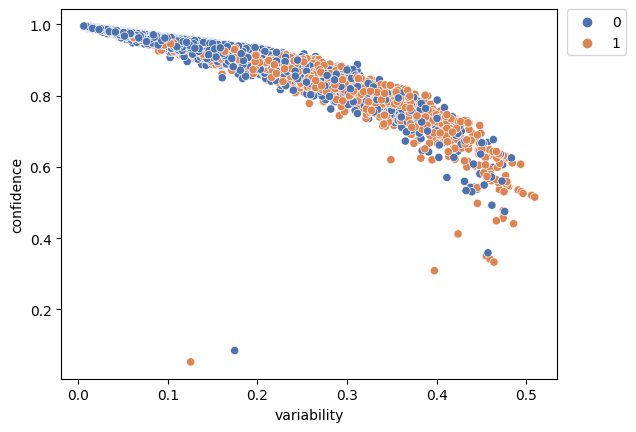

In [ ]:
sns.scatterplot(data=cartography_df, x="variability", y="confidence", hue='label', palette='deep')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

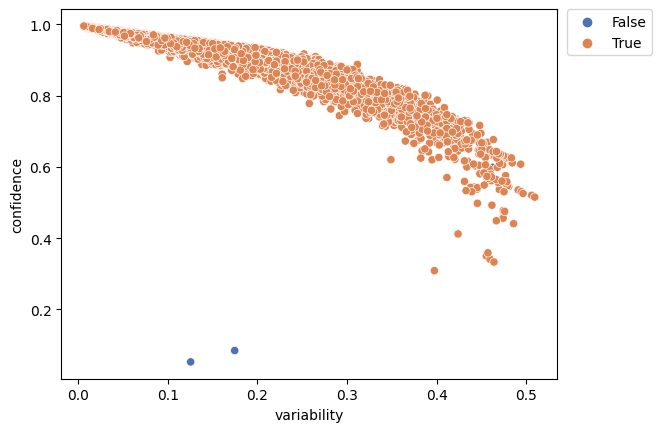

In [ ]:
sns.scatterplot(data=cartography_df, x="variability", y="confidence", hue='is_correct', palette='deep')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

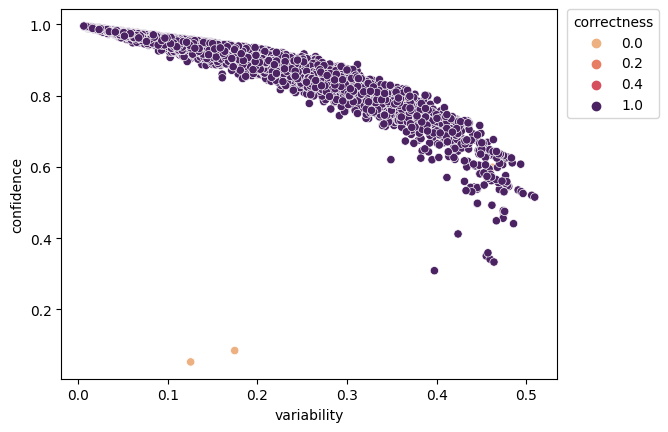

In [ ]:
sns.scatterplot(data=cartography_df, x="variability", y="confidence", hue='correctness', palette='flare')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title='correctness')
plt.savefig("conf_vs_var_color_correctness.png", dpi=600, bbox_inches='tight')

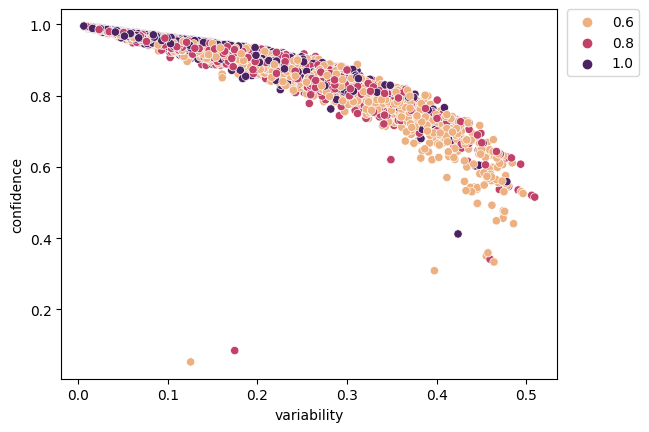

In [ ]:
sns.scatterplot(data=cartography_df, x="variability", y="confidence", hue='agreement_factor', palette='flare')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig("conf_vs_var_color_agreement_factor.png", dpi=600, bbox_inches='tight')

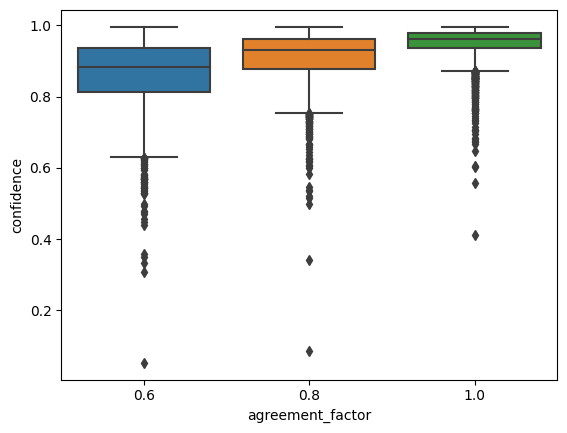

In [ ]:
sns.boxplot(cartography_df, x='agreement_factor', y='confidence')
plt.savefig("conf_vs_agreement_factor.png", dpi=600, bbox_inches='tight')

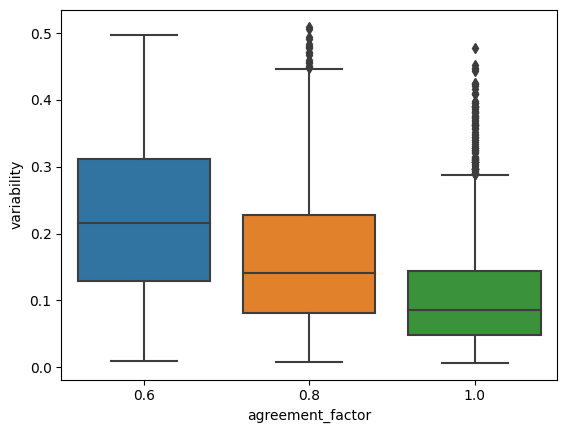

In [ ]:
sns.boxplot(cartography_df, x='agreement_factor', y='variability')
plt.savefig("var_vs_agreement_factor.png", dpi=600, bbox_inches='tight')

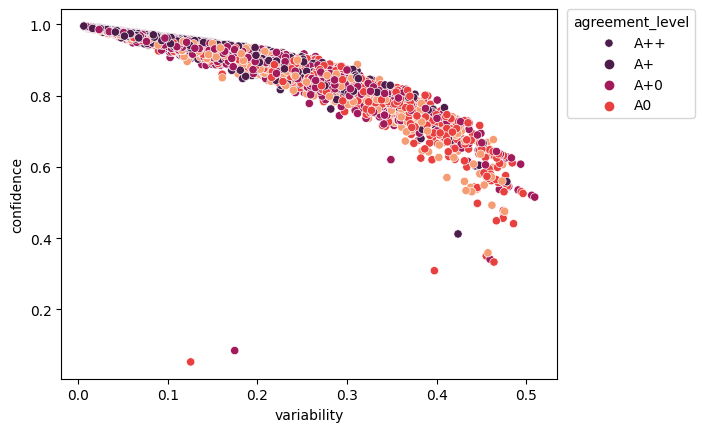

In [ ]:
g = sns.scatterplot(data=cartography_df, x="variability", y="confidence", hue='agreement_level', palette='rocket')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, labels = ['A++','A+','A+0', 'A0'], title='agreement_level')
plt.savefig("conf_vs_var_color_agreement_level.png", dpi=600, bbox_inches='tight')

In [ ]:
cartography_df.head()

,text_id,text,label_0_mean,label_0_std,label_0_last,label_1_mean,label_1_std,label_1_last,label,pred,agreement_level,agreement_factor,confidence,variability,correctness,is_correct
0,1,No way Jose!!,0.888315,0.156509,0.985620,0.111685,0.156509,0.014380,0,0,A++,1.0,0.888315,0.156509,1.0,True
1,5,This earpiece too plus a wire on his sleeves...,0.752475,0.209807,0.983456,0.247525,0.209807,0.016544,0,0,A+,0.8,0.752475,0.209807,1.0,True
2,6,Please lost you yelling insanely at the sk...,0.328549,0.292129,0.016296,0.671451,0.292129,0.983704,1,1,A+0,0.6,0.671451,0.292129,1.0,True
3,7,Dang it!!,0.832625,0.213461,0.961879,0.167375,0.213461,0.038121,0,0,A++,1.0,0.832625,0.213461,1.0,True
4,9,Elections have consequences 101: - Republican...,0.755600,0.241671,0.985135,0.244400,0.241671,0.014865,0,0,A0,0.6,0.755600,0.241671,1.0,True


In [ ]:
cartography_df.sort_values(['confidence']).head(10)

,text_id,text,label_0_mean,label_0_std,label_0_last,label_1_mean,label_1_std,label_1_last,label,pred,agreement_level,agreement_factor,confidence,variability,correctness,is_correct
2690,4540,#police officer murdered by democrat black com...,0.965650,0.016736,0.979606,0.034350,0.016736,0.020394,1,0,A+0,0.6,0.034350,0.016736,0.0,False
738,1241,Coronavirus panic deflates extreme bullishness...,0.952367,0.054463,0.987635,0.047633,0.054463,0.012365,1,0,A+,0.8,0.047633,0.054463,0.0,False
628,1062,Omg you are such a sheep Russia and Puti...,0.056353,0.056097,0.005387,0.943647,0.056097,0.994613,0,1,A0,0.6,0.056353,0.056097,0.0,False
1693,2883,You’re nutz hair lady.,0.062297,0.024362,0.090427,0.937703,0.024362,0.909573,0,1,A0,0.6,0.062297,0.024362,0.0,False
3810,6392,"To whom it may concern, Due to your #un...",0.934540,0.059466,0.971275,0.065460,0.059466,0.028725,1,0,A+,0.8,0.065460,0.059466,0.0,False
811,1367,He is fighting for his wife’s cushy job the ol...,0.087565,0.040184,0.111476,0.912435,0.040184,0.888524,0,1,A0,0.6,0.087565,0.040184,0.2,False
3787,6350,#BlackLivesMatter = black lives killed by whit...,0.908300,0.027320,0.925065,0.091700,0.027320,0.074935,1,0,A+0,0.6,0.091700,0.027320,0.0,False
2731,4605,All the sudden black lives matters to these bi...,0.099364,0.097917,0.006331,0.900636,0.097917,0.993669,0,1,A+,0.8,0.099364,0.097917,0.0,False
3353,5626,Proud boys. Criminal taxes. Let people die rat...,0.106481,0.056305,0.147245,0.893519,0.056305,0.852755,0,1,A0,0.6,0.106481,0.056305,0.2,False
3717,6233,America is a country of racism #GeorgeFloydP...,0.877962,0.087124,0.949029,0.122038,0.087124,0.050971,1,0,A+,0.8,0.122038,0.087124,0.0,False
